# Race Dashboard



This document describes the requirements and design decisions we will adopt for the Race Dashboard for the Sanofi Asset Efficiency challenge.  This document is intended to provide a detailed explanation of what is to be included on the dashboard, required data sources, and assumptions being made in the design.  It will also show the steps for getting the data into the necessary format.

## Scope/objective

The objective is to be able to display the documented metrics and categories as best suited on a Dashboard presentation for Sanofi staff to be able to access.


## Metrics / categories
The metrics have been mapped into sectors to mimic different sectors of a race track.  The metrics are:
 
 
 
•     Race = 8 Laps = 8 Months   
•     Lap = Monthly Progress   
<br>
<br>

•     **Sector 1 = OEE Improvement   
•     Sector 2 = OEE Variability Improvement   
•     Sector 3 = Stoppage Reduction   
•     Sector 4 = Changeover Improvement**   
• _Sector 5 = Most effective OEE application   
• Sector 6 = Best Innovation   
• Sector 7 = Most consistent OEE improvement progress   
• Sector 8 = Collaboration   
• Sector 9 = Team Spirit_

 
 


| Change log |
|:----------:|    


| Date | Initials | Comments |
|------|:---------|:---------|
| 2021-06-23 | MC | in leaderboard, replace NaN values in laptime calc with the max laptime for that lap
| 2021-06-23 | MC | use race review dates for grouping data, rather than calendar months
| 2021-06-24 |JB | missing OEE_Diff figures should default to 'OEE %' - OEE start point, not just 'OEE %' value
| 2021-06-24 |JB | for sector one, multiply sum of OEE_Diff by -1.  (was doing this in Tableau calcs but too late for lap_time calc).
|2021-06-25 | MC | in leaderboard, change prev_race_time calc to include all but last 2 cols, to handle new race cols as they arrive
|2021-06-28 | MC | correct dates in nominations spreadsheet, and merge on 1 row with a date within the review period
|2021-06-29 | MC | corrected nominations spreadsheet for Lisieux IWK - should be TR200 Packaging
|2021-06-30 | MC | populate missing OEE % values before calculating rolling_std using the OEE % column
|2021-06-30 | MC | remove start_changeover_calc merge as it's not being used any more, and was dropping rows
|2021-07-06 | MC | populate missing OEE % values with OEE from previous week for that site.
|2021-07-12 | MC | import nominations for sectors 10 and 11
|2021-08-21 | MC | create a Plant Line column and pass into df_weekly_with_calcs for dash presentation
|2021-08-21 | MC | add sector 12 for Better Together.  Apply 25% weighting

In [2]:
import pandas as pd
import numpy as np
import datetime
import os


# Viz libs
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# display options
# pd.options.display.float_format = "{:.2f}".format


import set_config


## Read file and cleanse

- qliksense_oee_extract.xlsx should contain the OEE metrics latest data from QS by week number
- qliksense_asset_dashboard.xlsx has a list of plants/sites taking part, with original target OEE and some other Sanofi target information

#### Cleaning required:   
- OEE % needs converting to numeric, coerce the nulls to nan values
- I think W53-2020 data is bobbings - causes dup indexes for date 2021-01-10 and don't need 2020 data anyway...so dropping it
- check for missing OEE start points

In [3]:

dir_local = set_config.ConfigSectionMap("SectionOne")['local']
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_race = set_config.ConfigSectionMap("SectionOne")['race']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))

# pd.set_option('display.max_columns', None)
# pd.set_option('max_colwidth', None)

dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/


In [4]:
def read_excel_file(passed_dir, filename):
    path = os.path.join(passed_dir, filename)
    temp_df = pd.read_excel(path)
    return temp_df

folder = 'Race Dashboard data'

file = ('qliksense_oee_extract.xlsx')
df_weekly = read_excel_file(dir_race, file)

file = ('qliksense_asset_dashboard.xlsx')
df_dash = read_excel_file(dir_race, file)

df_weekly = df_weekly.loc[df_weekly['Week'].str.contains('2021')]
df_weekly['OEE %'] = pd.to_numeric(df_weekly['OEE %'], errors='coerce')
df_weekly['Changeover'] = pd.to_numeric(df_weekly['Changeover'], errors='coerce')
df_weekly['Unplanned_tech_loss'] = pd.to_numeric(df_weekly['Unplanned_tech_loss'], errors='coerce')
# don't use their progress figure as it's a static val
df_dash.rename(columns={'⇗ OEE% progress':'OEE% progress'}, inplace=True)

In [5]:
# identify any rows without a start OEE and fix them manually in the following cell (can't be bothered to automate as there was only one!)
index_to_fix = df_dash[~df_dash['OEE  Start point'].apply(np.isreal)].index

In [6]:
# df_dash.loc[index_to_fix] = 0.585
df_dash['OEE  Start point'].loc[index_to_fix] = 0.585
df_dash

,Plant,Line,OEE Start point,OEE% progress,OEE% _last_4_w,Capa uti last 4w,On_track_OEE,Way to Prog Target (65%),CO_4w_ptOEE%,TA%_Last4W
0,Origgio,ORI - EG096,0,0,0.0 % +/-0 % ▼,100,☂,0.65,0.0 %▲,1
1,Maisons-Alfort,MAF - C7 Packaging Line,0,0,0.0 % +/-0 % ▼,70.017953,☂,0.65,0.0 %▲,1
2,ANAGNI,ANA - Pack 1,0,0,0.0 % +/-0 % ▼,13.864998,☂,0.65,0.0 %▲,1
3,MARCY L'ETOILE,MLE - P2A1,0.156518,-0.156518,0.0 % +/-0 % ▼,0.019623,☂,0.65,0.0 %▼,1
4,Le Trait,LTR - C10 Packaging Line,0.215095,-0.215095,0.0 % +/-0 % ▼,0.009811,☂,0.65,0.0 %▼,1
...,...,...,...,...,...,...,...,...,...,...
285,- No translation,ELB - FERMENTATION E10,0.739402,-,+/- ▼,-,☂,-,▼,-
286,- No translation,ELB - FERMENTATION E11,0.606476,-,+/- ▼,-,☂,-,▼,-
287,- No translation,ELB - FERMENTATION V08,0.230105,-,+/- ▼,-,☂,-,▼,-
288,- No translation,ELB - FERMENTATION V09,0.260532,-,+/- ▼,-,☂,-,▼,-


#### Dates for the Asset Challenge

Start Date is going to be fixed as 2021-04-01. Remove all the rows from df_weekly before this date

Review Date will move and act as a cutoff for each Race meeting

In [7]:
# we're ignoring data from before 2021-04-01
start_date = '2021-04-01'

# this is needed to prevent including additional values in the race time.
# 	Review_Date
# 0	2021-04-15
# 1	2021-05-13
# 2	2021-06-10
# 3	2021-07-08
# 4	2021-08-19
# 5	2021-09-16
# 6	2021-10-14
# 7	2021-11-18

review_date = '2021-12-02'


create a datetime from the week number

In [8]:
df_weekly['WeekOfYear'] = pd.to_numeric(df_weekly['Week'].str[1:3])
df_weekly['Year'] = pd.to_numeric(df_weekly['Week'].str[4:])
dates = df_weekly.Year*100+df_weekly.WeekOfYear
df_weekly['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
# df_weekly.drop(columns=['Year','WeekOfYear'], inplace=True)
df_weekly.head()

,Week,Line,OEE %,Changeover,Unplanned_tech_loss,Availability %,Performance %,Quality %,WeekOfYear,Year,Date
33,W01-2021,"FRA - FF NLP, M18 Filling",NaN,NaN,NaN,-,-,-,1,2021,2021-01-10
34,W01-2021,"FRA - FF NLP, M18 Inspection",0.076494,0.109907,0.057656,0.822558,0.092995,1,1,2021,2021-01-10
35,W01-2021,"FRA - FF NLP, M21 Filling",0.317747,0.686965,0.082621,0.256039,1.241011,1,1,2021,2021-01-10
36,W01-2021,"FRA - FF NLP, M21 Inspection",0.129049,0.000000,0.100696,0.906558,0.142351,1,1,2021,2021-01-10
37,W01-2021,"FRA - FF NLP, M22 Filling",0.000012,0.999994,0.000000,0.000006,2.1,1,1,2021,2021-01-10


In [9]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7783 entries, 33 to 9962
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Week                 7783 non-null   object        
 1   Line                 7783 non-null   object        
 2   OEE %                5845 non-null   float64       
 3   Changeover           5834 non-null   float64       
 4   Unplanned_tech_loss  5834 non-null   float64       
 5   Availability %       7783 non-null   object        
 6   Performance %        7783 non-null   object        
 7   Quality %            7783 non-null   object        
 8   WeekOfYear           7783 non-null   int64         
 9   Year                 7783 non-null   int64         
 10  Date                 7783 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 729.7+ KB


Calculating a McLaren start_oee from qliksense data pre 2021-03-31 - where it's available.
This was done to highlight the Sanofi start points were a bit random

In [10]:
# set start_oee_date to the min date in df_weekly
start_oee_date = df_weekly.Date.min()
# up to before April
end_oee_date = '2021-03-31'

df_dates=df_weekly[(df_weekly.Date >= start_oee_date) & (df_weekly.Date <= end_oee_date) ]
df_dates = df_dates.groupby(['Line'])[['OEE %']].mean().reset_index()
df_dates.rename(columns={'OEE %':'McL_Start_OEE'}, inplace=True)
df_dash = df_dash.merge(df_dates, on='Line', how='outer')



Write out to excel for later

In [11]:
filename = 'QSDashboard_McL.xlsx'
df_dash.to_excel(os.path.join(dir_race, filename))

In [12]:
#merge the 2 dataframes to get the start OEE
# use 'Way to Prog Target (65%)' instead of 'OEE% Target (2022)'
# df_weekly = df_weekly.merge(df_dash[['Plant','Line', 'OEE  Start point','OEE% Target (2022)', 'McL_Start_OEE']],on='Line')
df_weekly = df_weekly.merge(df_dash[['Plant','Line', 'OEE  Start point','Way to Prog Target (65%)', 'McL_Start_OEE']],on='Line')

There was a problem with the TRS (Tours) data from Sanofi and this was a temporary fix needed to stop it trashing all the other calculations.  Needed to remove TRS in a few places to prevent outer joins going wild

In [13]:
# drop TRS for the time being because they've broken their data source!
# df_weekly = df_weekly[~df_weekly.Line.str.contains('TRS')]
# df_weekly[df_weekly.Line.str.contains('TRS')]

In [14]:
df_weekly.groupby(['Line','OEE  Start point']).mean()

OEE %  Changeover  \
Line                           OEE  Start point                         
ANA - Fiale 6                  0.157792          0.110189    0.101680   
ANA - Fiale 7                  0.016778               NaN         NaN   
ANA - Pack 1                   0.000000               NaN         NaN   
ELB - Extraction B12 1st cycle 0.585000          0.652663    0.000000   
                               0.916388          0.652663    0.000000   
...                                                   ...         ...   
WAT - AIL2 Packaging           0.414929          0.466616    0.155265   
WAT - LYO INSPECTION           5.113115          3.674140    0.002257   
WAT - LYO Packaging Line 3     0.114513          0.169478    0.255175   
WAT - LYO Packaging Line 9     0.240593          0.272339    0.233528   
WAT - PFS Filling Line         0.585000               NaN         NaN   

                                                 Unplanned_tech_loss  \
Line                           OEE  Start point                        
ANA - Fiale 6                  0.157792                     0.482401   
ANA - Fiale 7                  0.016778                          NaN   
ANA - Pack 1                   0.000000                          NaN   
ELB - Extraction B12 1st cycle 0.585000                     0.169830   
                               0.916388                     0.169830   
...                                                              ...   
WAT - AIL2 Packaging           0.414929                     0.380960   
WAT - LYO INSPECTION           5.113115                     0.649997   
WAT - LYO Packaging Line 3     0.114513                     0.325499   
WAT - LYO Packaging Line 9     0.240593                     0.427093   
WAT - PFS Filling Line         0.585000                          NaN   

                                                 WeekOfYear    Year  \
Line                           OEE  Start point                       
ANA - Fiale 6                  0.157792                50.5  2021.0   
ANA - Fiale 7                  0.016778                52.0  2021.0   
ANA - Pack 1                   0.000000                52.0  2021.0   
ELB - Extraction B12 1st cycle 0.585000                37.0  2021.0   
                               0.916388                37.0  2021.0   
...                                                     ...     ...   
WAT - AIL2 Packaging           0.414929                47.0  2021.0   
WAT - LYO INSPECTION           5.113115                47.0  2021.0   
WAT - LYO Packaging Line 3     0.114513                47.0  2021.0   
WAT - LYO Packaging Line 9     0.240593                47.0  2021.0   
WAT - PFS Filling Line         0.585000                50.0  2021.0   

                                                 McL_Start_OEE  
Line                           OEE  Start point                 
ANA - Fiale 6                  0.157792                    NaN  
ANA - Fiale 7                  0.016778                    NaN  
ANA - Pack 1                   0.000000                    NaN  
ELB - Extraction B12 1st cycle 0.585000                    NaN  
                               0.916388                    NaN  
...                                                        ...  
WAT - AIL2 Packaging           0.414929                    NaN  
WAT - LYO INSPECTION           5.113115                    NaN  
WAT - LYO Packaging Line 3     0.114513                    NaN  
WAT - LYO Packaging Line 9     0.240593                    NaN  
WAT - PFS Filling Line         0.585000                    NaN  

[253 rows x 6 columns]

Now we can remove all the rows from df_weekly before start date


In [15]:
df_weekly = df_weekly[df_weekly['Date'] > start_date].sort_values('Date')



#### Populate missing OEE %
2021-06-07 - change of plan! Populating with min OEE value does not work when some Lines record 0% OEE.  Missing values can be just delayed data collection which sorts itself later.  So, until proper data arrives:

- Use the previous week's value (ffill) for that Line.  This will still leave NaN if they existed in the first row(s).  
- populate the remaining NaN with 'OEE  start point'
- ~~Find the weekly min/max OEE % from any site~~   
- ~~Merge those columns into df_weekly~~   
- ~~fill any NaN with the min OEE we calc'd for that week~~    


In [16]:
# df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['OEE %'].abs())
#        .groupby(pd.Grouper(key='Date',freq='W'))['OEE %'].agg([('Min' , 'min'), ('Max', 'max')])
#        .add_prefix('Week'))
# df_weekly_minmax.reset_index(inplace=True)
# df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekMin','WeekMax']])
# df_weekly['OEE %'].fillna(df_weekly.WeekMin, inplace=True)
# df_weekly.drop(columns=['WeekMin','WeekMax'], inplace=True)
df_weekly['OEE %'] = df_weekly.sort_values(['Line','Date']).groupby(['Line'])['OEE %'].ffill()
df_weekly['OEE %'] = df_weekly.sort_values(['Line','Date']).groupby(['Line'])['OEE %'].fillna(df_weekly['OEE  Start point'])
# df_weekly[df_weekly['OEE %'].isna()]


## Standard Deviation
Calculate std_dev and mean on a 4 week rolling basis

Standard deviation is the square root of the variance, so no need to calculate both and have left var out

In [17]:
df_weekly['rolling_std'] = df_weekly.sort_values(['Line','Date']).groupby('Line')['OEE %'].apply(lambda x : x.rolling(4,1).agg(np.std))

In [18]:
filename = ('Nominations Category Scoring.xlsx')
path = os.path.join(dir_race, filename)
# import cols A:L - increased to bring in extra sector of Replicate
df_nom_sectors = pd.read_excel(path, sheet_name='Nomination scoring', usecols="A:L", parse_dates=['Date'])

If they change the Line names between dashboard and the nominations spreadsheet we will not match and the next calcs won't work.

Need to get the nomination Lines to match the latest dashboard names.  Decided to do it here:

```

df_nom_sectors.Line.replace(to_replace={
'M18 Filling':'FRA - FF NLP, M18 Filling', 
'L18 Packaging Line':'TRS - L18 Packaging Line', 
'IMA C80/2':'SCO - IMA C80/2',
'M21 Filling':'FRA - FF NLP, M21 Filling', 
'L25 Packaging Line':'TRS - L25 Packaging Line', 
'GAMMA1':'SCO - GAMMA1',
'M22 Filling':'FRA - FF NLP, M22 Filling', 
'C9 Packaging Line':'MAF - C9 Packaging Line', 
'AL6':'FRA - Devices Pens, AL6',
'AL5 Packaging 1':'FRA - Devices Pens, AL5 Packaging 1', 
'C2 Packaging Line':'MAF - C2 Packaging Line',
'SUPPO Packaging Line':'LSX - SUPPO Packaging Line', 
'TR200 Packaging Line':'LSX - TR200 Packaging Line',
'MEDISEAL PURAN':'SUZ - MEDISEAL PURAN', 
'IMA-2 Packaging (SOLD)':'LLB - IMA-2 Packaging (SOLD)',
'LINE 01 - UHLMANN 1880':'SUZ - LINE 01 - UHLMANN 1880', 
'Bosch-2 Packaging (SOLD)':'LLB - Bosch-2 Packaging (SOLD)'
}, inplace=True)

```

In [19]:
df_nom_sectors.Line.replace(to_replace={
'M18 Filling':'FRA - FF NLP, M18 Filling', 
'L18 Packaging Line':'TRS - L18 Packaging Line', 
'IMA C80/2':'SCO - IMA C80/2',
'M21 Filling':'FRA - FF NLP, M21 Filling', 
'L25 Packaging Line':'TRS - L25 Packaging Line', 
'GAMMA1':'SCO - GAMMA1',
'M22 Filling':'FRA - FF NLP, M22 Filling', 
'C9 Packaging Line':'MAF - C9 Packaging Line', 
'AL6':'FRA - Devices Pens, AL6',
'AL5 Packaging 1':'FRA - Devices Pens, AL5 Packaging 1', 
'C2 Packaging Line':'MAF - C2 Packaging Line',
'SUPPO Packaging Line':'LSX - SUPPO Packaging Line', 
'TR200 Packaging Line':'LSX - TR200 Packaging Line',
'MEDISEAL PURAN':'SUZ - MEDISEAL PURAN', 
'IMA-2 Packaging (SOLD)':'LLB - IMA-2 Packaging (SOLD)',
'LINE 01 - UHLMANN 1880':'SUZ - LINE 01 - UHLMANN 1880', 
'Bosch-2 Packaging (SOLD)':'LLB - Bosch-2 Packaging (SOLD)'
}, inplace=True)

In [20]:
df_weekly.Line.unique()

array(['FRA - FF NLP, M18 Filling', 'OCO - MELOX Packaging Line',
       'OCO - NOACK 2 Packaging Line', 'OCO - PARTENA 1 Packaging Line',
       'OCO - PARTENA 2 Packaging Line', 'OCO - PARTENA 3 Packaging Line',
       'OCO - SUSPENSIONES Packaging Line',
       'OCO - UHLMANN 1 Packaging Line', 'OCO - UHLMANN 2 Packaging Line',
       'SCO - GAMMA1', 'SCO - GAMMA2', 'SCO - GAMMA3', 'SCO - Gamma4',
       'SCO - IMA C80/1', 'SCO - IMA C80/2', 'SCO - IMA C80/3',
       'SCO - PAR102', 'SCO - PART92', 'SCO - U3', 'SCO - WNPAC2',
       'SZX - Packaging line 1', 'SZX - Packaging line 2',
       'SZX - Packaging line 3', 'TRS - L15 Packaging line',
       'TRS - L16 Packaging Line', 'TRS - L17 Packaging Line',
       'OCO - MEDISEAL Packaging Line', 'OCO - LACTACYD Packaging Line',
       'OCO - JARABES Packaging Line', 'OCO - C90 Packaging Line',
       'FRA - FF NLP, M22 Inspection', 'HZG - Blister packaging line 1',
       'HZG - Blister packaging line 2', 'HZG - Blister packaging lin

In [21]:
df_nom_sectors.Line.unique()

array(['TRS - L18 Packaging Line', 'TRS - L25 Packaging Line',
       'SUZ - LINE 01 - UHLMANN 1880', 'SUZ - MEDISEAL PURAN',
       'SCO - GAMMA1', 'SCO - IMA C80/2', 'MAF - C2 Packaging Line',
       'MAF - C9 Packaging Line', 'LSX - TR200 Packaging Line',
       'LSX - SUPPO Packaging Line',
       'FRA - Devices Pens, AL5 Packaging 1', 'FRA - Devices Pens, AL6',
       'FRA - FF NLP, M18 Filling', 'FRA - FF NLP, M21 Filling',
       'FRA - FF NLP, M22 Filling', 'LLB - Bosch-2 Packaging (SOLD)',
       'LLB - IMA-2 Packaging (SOLD)', 'LTR - C5 Packaging Line',
       'WAT - AIL2 ASSEMBLY'], dtype=object)

In [22]:
df_nom_sectors['Date'] = pd.Series(df_nom_sectors['Date']).fillna(method='ffill')
df_nom_sectors = df_nom_sectors.fillna(0)

df_weekly = df_weekly.merge(df_nom_sectors[['Line','Plant','Date','Best Solution','Best Innovation','Improvement Iterations','Lessons and Sharing','Team Contribution and Spirit','Changeover times','Number of stoppages', 'Better Together', 'Replicate']],how='outer', on=['Date','Plant','Line'])
df_weekly

,Week,Line,OEE %,Changeover,Unplanned_tech_loss,Availability %,Performance %,Quality %,WeekOfYear,Year,...,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate
0,W13-2021,"FRA - FF NLP, M18 Filling",0.046124,0.789781,0.114818,0.04983,0.925625,1,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W13-2021,OCO - MELOX Packaging Line,0.318493,NaN,NaN,-,-,-,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W13-2021,OCO - NOACK 2 Packaging Line,0.290258,0.265278,0.146215,0.441944,0.656775,1,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W13-2021,OCO - PARTENA 1 Packaging Line,0.164723,0.235691,0.200509,0.403119,0.408621,1,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,W13-2021,OCO - PARTENA 2 Packaging Line,0.000000,0.000000,0.000000,1,0,-,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7110,W52-2021,"FRA - FF NLP, M22 Inspection",0.000000,0.000000,0.999985,0.000015,0,-,52.0,2021.0,...,0.32171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7111,W52-2021,"FRA - FF Packaging, VL50",0.548981,NaN,NaN,-,-,-,52.0,2021.0,...,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7112,W52-2021,ANA - Pack 1,0.000000,NaN,NaN,-,-,-,52.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7113,NaN,WAT - AIL2 ASSEMBLY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Another temporary fix for TRS data issue

In [23]:
# drop TRS for the time being
# df_weekly = df_weekly[~df_weekly.Line.str.contains('TRS')]
# df_weekly[df_weekly.Line.str.contains('TRS')]

## Create review dates
create a review_date column for grouping the data later, so we only get the data we're interested in for each review

In [24]:
def thurs_of_weekbefore(year, week):
    return datetime.date.fromisocalendar(year, week-1, 4)  # (year, week before (w-1), thursday)

review_weeks = [16, 20, 24, 28, 34, 38, 42, 47, 49]
review_dates = []

for i in review_weeks:
    if i > 0:
        review_dates.append((thurs_of_weekbefore(2021,i)))

df_review_dates = pd.DataFrame(review_dates)
df_review_dates.rename(columns={0:'Review_Date'}, inplace=True)
df_review_dates['Review_Date'] = pd.to_datetime(df_review_dates.Review_Date)

# df_review_dates.info()
df_weekly = pd.merge_asof(df_weekly.sort_values('Date'), df_review_dates, left_on='Date', right_on='Review_Date', allow_exact_matches=True, direction='forward')
df_review_dates.sort_values(by='Review_Date')

,Review_Date
0,2021-04-15
1,2021-05-13
2,2021-06-10
3,2021-07-08
4,2021-08-19
5,2021-09-16
6,2021-10-14
7,2021-11-18
8,2021-12-02


#### We need the diff between the weekly OEE % figures, and the Weekly Changeover figures
Need something to calculate the OEE Progress and Changeover, otherwise we will have problems when we group and sum values later
- Create OEE_diff with OEE % from groupby of each Line, Week (only 1 row per week, so 'mean' will yield the same)   
- Find the diff between the rows in OEE_Diff for each Line   
- fillNA (first row for each Line) with OEE Start point - should only be needed on the first row for each Line   

repeat same logic for Changeover - there will be more NaN as start_changeover wasn't provided for all.  We populate this later

after merging with nominations spreadsheet we will have future dated rows that get in the way of calcs later - get rid of them using the review_date set earlier

In [25]:
df_weekly = df_weekly[df_weekly['Review_Date'] <= review_date]

In [26]:
# OEE_Diff = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','OEE %','OEE  Start point']]
# OEE_Diff['OEE_Diff'] = OEE_Diff.groupby('Line')['OEE %'].diff().fillna(df_weekly['OEE %'] - df_weekly['OEE  Start point'])
# df_weekly = df_weekly.merge(OEE_Diff[["Line","Date","OEE_Diff"]], on=(["Line","Date"]))
# df_weekly[["Line","Date","OEE %","OEE_Diff"]].sort_values(by=['Line', 'Date'])

df_weekly['OEE_Diff'] = df_weekly.sort_values(['Line','Date']).groupby('Line')['OEE %'].diff().fillna(df_weekly['OEE %'] - df_weekly['OEE  Start point'])



In [27]:
df_weekly['Changeover_Diff'] = df_weekly.sort_values(['Line','Date']).groupby('Line')['Changeover'].diff().fillna(0)

In [28]:
df_weekly['Changeover_rolling_mean'] = df_weekly.sort_values(['Line','Date']).groupby('Line')['Changeover'].apply(lambda x : x.rolling(4,1).mean())


#### Populate missing Unplanned Tech Loss

- Create weekly min/max cols for Unplanned tech loss from any site   
- Merge those columns into df_weekly   
- fill any NaN rows with the max Unplanned_tech_loss found for that week   

**this might be flawed!!** 

In [29]:
df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['Unplanned_tech_loss'].abs())
       .groupby(pd.Grouper(key='Date',freq='W'))['Unplanned_tech_loss'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('WeekUTL'))
df_weekly_minmax.reset_index(inplace=True)
df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekUTLMin','WeekUTLMax']])
df_weekly['Unplanned_tech_loss'].fillna(df_weekly.WeekUTLMax, inplace=True)
df_weekly.drop(columns=['WeekUTLMin','WeekUTLMax'], inplace=True)
df_weekly

,Week,Line,OEE %,Changeover,Unplanned_tech_loss,Availability %,Performance %,Quality %,WeekOfYear,Year,...,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean
0,W13-2021,"FRA - FF NLP, M18 Filling",0.046124,0.789781,0.114818,0.04983,0.925625,1,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,-0.397397,0.000000,0.789781
1,W13-2021,LLB - IMA-1 Packaging (SOLD),0.585000,NaN,0.700679,-,-,-,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.000000,0.000000,NaN
2,W13-2021,"FRA - FF NAPA, M24 Inspection",0.288613,NaN,0.700679,-,-,-,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.000000,0.000000,NaN
3,W13-2021,"FRA - FF NLP, M22 Filling",0.649336,0.035164,0.234635,0.724039,0.896824,1,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.119268,0.000000,0.035164
4,W13-2021,LLB - Bosch-2 Packaging (CEPH),0.585000,NaN,0.700679,-,-,-,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5911,W47-2021,LSX - SIG1 Packaging Line,0.615488,0.118539,0.091200,0.705099,0.882397,0.989248,47.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-02,0.074228,0.011383,0.124256
5912,W47-2021,SCO - IMA C80/2,0.618251,0.134107,0.178301,0.656353,0.941949,1,47.0,2021.0,...,82.0,97.0,0.0,0.0,0.0,0.0,2021-12-02,0.153205,-0.054514,0.160657
5913,W47-2021,RDG - Vial Packaging Line,0.371251,NaN,0.788144,-,-,-,47.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-02,0.000000,0.000000,NaN
5914,W47-2021,ELB - Extraction B12 1st cycle,0.252698,0.000000,0.649229,-0.298459,-0.846677,1,47.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-02,0.000000,0.000000,0.000000


#### Populate missing Changeover 

Now, this doesn't really work!  Sometimes the max value changeover for the week is 100%, and there isn't any correlation in my calc between OEE + Changeover + unplanned outage being < 100% ...

...but I don't think we're using/relying on changeover figure for sector calcs here or in tableau.  Going to remove these rows below.

In [30]:
df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['Changeover'].abs())
       .groupby(pd.Grouper(key='Date',freq='W'))['Changeover'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('WeekChangeover'))
df_weekly_minmax.reset_index(inplace=True)
df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekChangeoverMin','WeekChangeoverMax']])
df_weekly['Changeover'].fillna(df_weekly.WeekChangeoverMax, inplace=True)
df_weekly.drop(columns=['WeekChangeoverMin','WeekChangeoverMax'], inplace=True)
df_weekly

,Week,Line,OEE %,Changeover,Unplanned_tech_loss,Availability %,Performance %,Quality %,WeekOfYear,Year,...,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean
0,W13-2021,"FRA - FF NLP, M18 Filling",0.046124,0.789781,0.114818,0.04983,0.925625,1,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,-0.397397,0.000000,0.789781
1,W13-2021,LLB - IMA-1 Packaging (SOLD),0.585000,0.901961,0.700679,-,-,-,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.000000,0.000000,NaN
2,W13-2021,"FRA - FF NAPA, M24 Inspection",0.288613,0.901961,0.700679,-,-,-,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.000000,0.000000,NaN
3,W13-2021,"FRA - FF NLP, M22 Filling",0.649336,0.035164,0.234635,0.724039,0.896824,1,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.119268,0.000000,0.035164
4,W13-2021,LLB - Bosch-2 Packaging (CEPH),0.585000,0.901961,0.700679,-,-,-,13.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5911,W47-2021,LSX - SIG1 Packaging Line,0.615488,0.118539,0.091200,0.705099,0.882397,0.989248,47.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-02,0.074228,0.011383,0.124256
5912,W47-2021,SCO - IMA C80/2,0.618251,0.134107,0.178301,0.656353,0.941949,1,47.0,2021.0,...,82.0,97.0,0.0,0.0,0.0,0.0,2021-12-02,0.153205,-0.054514,0.160657
5913,W47-2021,RDG - Vial Packaging Line,0.371251,1.000000,0.788144,-,-,-,47.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-02,0.000000,0.000000,NaN
5914,W47-2021,ELB - Extraction B12 1st cycle,0.252698,0.000000,0.649229,-0.298459,-0.846677,1,47.0,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-02,0.000000,0.000000,0.000000


#### Populate missing start_changeover (NaN)
If we've got this far and you still don't have a start_changeover, then you're a new site and can have this week's Changeover value

These rows still have NaN Changeover values

In [31]:
df_weekly[['Line','Date','Changeover']][df_weekly['Changeover'].isna()]

,Line,Date,Changeover


In [32]:
# df_weekly[df_weekly['OEE  Start point']isna()]
df_weekly[df_weekly['OEE  Start point'].isna() == True]

,Week,Line,OEE %,Changeover,Unplanned_tech_loss,Availability %,Performance %,Quality %,WeekOfYear,Year,...,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean
5401,NaN,WAT - AIL2 ASSEMBLY,NaN,0.890476,0.594870,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-11-18,NaN,0.0,0.088490
5806,NaN,WAT - AIL2 ASSEMBLY,NaN,1.000000,0.788144,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-12-02,NaN,0.0,0.313763


In [33]:
df_weekly[df_weekly['Way to Prog Target (65%)'].isna()]

,Week,Line,OEE %,Changeover,Unplanned_tech_loss,Availability %,Performance %,Quality %,WeekOfYear,Year,...,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Better Together,Replicate,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean
5401,NaN,WAT - AIL2 ASSEMBLY,NaN,0.890476,0.594870,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-11-18,NaN,0.0,0.088490
5806,NaN,WAT - AIL2 ASSEMBLY,NaN,1.000000,0.788144,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-12-02,NaN,0.0,0.313763


In [34]:
# df_weekly.start_changeover.fillna(df_weekly.Changeover, inplace=True)
df_weekly['OEE  Start point'].fillna(df_weekly['OEE %'], inplace=True)
df_weekly['Way to Prog Target (65%)'].fillna(0.65, inplace=True)

### Calculating Sector times


The lap time is a sum of the calculated sector scores + the pole position time from the F1 race data (eg for Paul Ricard it was 88 secs):



Sector [1-4] calculations   
**sector 1**
How much has your OEE increased / decreased?  Sum difference between each week and multiply total by -1.  This provides a negative figure to subtract from your laptime, so that larger OEE increase is rewarded with a bigger reduction in laptime

df_weekly['sector_1'] = df_weekly['OEE_Diff'].mul(-1)

OEE_Diff calculation
- Sort values by Line and Date
- Find the difference between each weekly OEE figure
- ~~Fill NaN values from missing OEE figures with the weekly OEE minus OEE Start Point for that site~~   
- any missing OEE figures will already be populated with previous week's value or the start OEE value


**Sector 2** 
How big was your rolling std deviation this period, over the previous 4 weeks std dev?  

df_weekly['sector_2'] = df_weekly['rolling_std']

rolling_std = rolling std deviation for past 4 weeks for each site


 
**Sector 3**
We want to reduce Unplanned tech loss (recorded as % of OEE) Unplanned tech loss is calculated within QlikSense but missing values sometimes.  Fill the missing values and then display the average Unplanned tech loss :

df_weekly['sector_3'] = df_weekly['Unplanned_tech_loss']


Populate missing unplanned tech loss:
- Create weekly min/max cols for Unplanned tech loss from any site
- Merge those columns into df_weekly
- fill any NaN unplanned tech loss rows with the max OEE calc'd for that week (bigger is worse)

 
**Sector 4**
We're trying to reduce changeover time (recorded as % of OEE).  
Start changeover value isn't provided, so calc our own start point for each Line using the average changeover in 2021 up to 30 April, 2021.
   
start_changeover_calc = df_weekly[['Plant','Line','Changeover']][df_weekly['Date'] < '2021-04-30'].groupby(['Plant','Line']).mean().reset_index()
start_changeover_calc.rename(columns={'Changeover':'start_changeover'}, inplace=True)
df_weekly = df_weekly.merge(start_changeover_calc[['Line','start_changeover']])



df_weekly['sector_4'] = df_weekly['Changeover_rolling_mean']

Changeover_mean = df_weekly.sort_values(by=['Line', 'Date'])[['Line', 'Date', 'Changeover', 'start_changeover']]   
Changeover_mean['Changeover_rolling_mean'] = Changeover_mean.groupby('Line')['Changeover'].apply(lambda x : x.rolling(4,1).mean())
df_weekly = df_weekly.merge(Changeover_mean[["Line","Date","Changeover_rolling_mean"]], on=(["Line","Date"]))



**Clean the sectors of NaN before summing them**   
Sometimes, when we haven't got enough information for pct_change calcs, we were getting no values coming through for the lap_time.  We should make sure there is a value in each of the sectors, otherwise there is an unfair advantage by not having data available.  Find all NaN values and replace with the mean for that column(sector)

**Sectors 5 - 9**   
Now sectors 5 - 13!!   
These scores are taken from the Nomination process.  Read in the Nomination s/s, merge any values we find with df_weekly, replace all NaN (missing) values with 0, and reduce the scores we find to 5% of their original value.  This value is then subtracted from the lap_time - so the better you do in the nominations the more your lap_time gets reduced by.

 
**lap_time**   
add up all the columns referencing 'sector'
df_weekly['lap_time'] = df_weekly.filter(regex='sector').sum(axis=1)


In [35]:
# df_weekly['sector_1'] = (df_weekly['WeekMax'] - df_weekly['OEE %'])
# df_weekly['sector_1'] = (df_weekly['OEE  Start point'] - df_weekly['OEE %'])
df_weekly['sector_1'] = df_weekly['OEE_Diff'].mul(-1)
df_weekly['sector_2'] = df_weekly['rolling_std']
df_weekly['sector_3'] = df_weekly['Unplanned_tech_loss']
# df_weekly['sector_4'] = (df_weekly['start_changeover'] - df_weekly['Changeover'])
# df_weekly['sector_4'] = (df_weekly['Changeover'] - df_weekly['start_changeover'])
df_weekly['sector_4'] = df_weekly['Changeover_rolling_mean']
# take 5% of the sector5-9 scores 
df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11','sector_12','sector_13']] = df_weekly[['Best Solution','Best Innovation','Improvement Iterations','Lessons and Sharing','Team Contribution and Spirit','Changeover times','Number of stoppages','Better Together','Replicate']] * -0.05
df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11','sector_12','sector_13']] = df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11','sector_12','sector_13']].fillna(0)
# Apply 25% weighting to Better Together sector
df_weekly[['sector_12']] = df_weekly[['sector_12']] * 1.25

# we'll use these in the absence of values for a sector
df_weekly[['sector_1','sector_2','sector_3','sector_4']] = df_weekly[['sector_1','sector_2','sector_3','sector_4']].fillna(df_weekly[['sector_1','sector_2','sector_3','sector_4']].mean())

#this will sum and handle the NaN
# df_weekly['lap_time'] = df_weekly[['sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9']].sum(axis=1)
df_weekly['lap_time'] = df_weekly.filter(regex='sector').sum(axis=1)

# now add the pole['Laptime'] from fastf1 to the lap_time adjustment we've created
# just use 88 secs rather than playing with timedeltas for now
# df_weekly['lap_time'] = pole['LapTime'] + pd.to_timedelta(df_weekly['lap_time'], unit='S')
# df_weekly['lap_time'] = 88 + df_weekly['lap_time']
df_weekly.groupby(['Line', pd.Grouper(key='Date', freq='W')])['lap_time'].sum()
# print (df_weekly['sector_1_time'] , df_weekly['sector_2_time'] , df_weekly['sector_3_time'], df_weekly['sector_4_time'])

Line                            Date      
ELB - Extraction B12 1st cycle  2021-06-06    1.253618
                                2021-06-13    0.169666
                                2021-06-20    0.686989
                                2021-06-27    0.048489
                                2021-07-04    0.152466
                                                ...   
WAT - LYO Packaging Line 9      2021-10-31    0.531799
                                2021-11-07    0.706952
                                2021-11-14    0.709514
                                2021-11-21    0.697108
                                2021-11-28    0.793797
Name: lap_time, Length: 5637, dtype: float64

Needed to get 3 letters from the Plant and Line to create 'Plant Line', for displaying on the dashboard later, but they've changed the names coming from qliksense so it's got to change again...but what to do this time (oct).  This is what was coming through:

```
df_weekly.Line.unique()

array(['FRA - FF NLP, M18 Filling', 'FRA - Devices Pens, AL5 Packaging 1',
       'FRA - FF NLP, M21 Filling', 'FRA - FF NLP, M22 Filling',
       'LSX - TR200 Packaging Line', 'MAF - C2 Packaging Line',
       'LSX - SUPPO Packaging Line', 'SCO - GAMMA1',
       'FRA - Devices Pens, AL6', 'SCO - IMA C80/2',
       'TRS - L18 Packaging Line', 'TRS - L25 Packaging Line',
       'MAF - C9 Packaging Line', 'SUZ - MEDISEAL PURAN',
       'SUZ - LINE 01 - UHLMANN 1880', 'LLB - IMA-2 Packaging (SOLD)',
       'LLB - Bosch-2 Packaging (SOLD)', 'LTR - C5 Packaging Line'],
      dtype=object)
      

df_weekly.Plant.unique()

array(['Frankfurt', 'Lisieux', 'Maisons-Alfort', 'SCOPPITO', 'Tours',
       'SUZANO', 'Luleburgaz', 'Le Trait'], dtype=object)
      
```

I think they've changed their naming again and it doesn't matter now.  Keeping this in case it doesn't remain in their dashboard.

In [36]:
# create PlantLine from the 1st three chars of Plant turned into uppercase + " " + first chars of Line up to the first whitespace
# df_weekly['Plant Line'] = df_weekly.Plant.apply(lambda x: x[:3].upper() if type(x)==str else x) + " " + df_weekly.Line.apply(lambda x: x.split()[0] if type(x)==str else x)

# Names have changed again - just use their Line names and sort it on the dashboard later.
df_weekly['Plant Line'] = df_weekly.Line

# do need this replace anymore
# df_weekly['Plant Line'].replace({
#     'SUZ LINE':'SUZ UHLMANN'
# }, inplace=True)

# df_weekly.head()

In [37]:
df_weekly.loc[df_weekly.Line.str.contains('Filling'), 'Process'] = 'FILLING'
df_weekly.loc[df_weekly.Line.str.contains('Packaging'), 'Process'] = 'PACKAGING'
# they were calling AL6 assembly packaging in Sept, so using that
df_weekly.loc[df_weekly.Line.str.contains('AL6'), 'Process'] = 'ASSEMBLY_PACKAGING'
# everything else looks like they class as 'PACKAGING'
df_weekly.loc[df_weekly.Process.isna(), 'Process'] = 'PACKAGING'

In [38]:
# tag on the process column for some grouping in the charts
# no longer works as latest version of qliksense dashboard doesn't have 'Process'
# df_weekly = df_weekly.merge(df_dash[['Line','Process']], on='Line')


In [39]:
df_weekly.Line.unique()

array(['FRA - FF NLP, M18 Filling', 'LLB - IMA-1 Packaging (SOLD)',
       'FRA - FF NAPA, M24 Inspection', 'FRA - FF NLP, M22 Filling',
       'LLB - Bosch-2 Packaging (CEPH)', 'LLB - SPREY Packaging (NSL)',
       'LLB - Sarong Packaging (SSL)', 'MAF - R1 Filling Line',
       'LLB - IMA-2 Packaging (NSL)', 'LLB - IMA-1 Packaging (NSL)',
       'MAF - R4 Filling Line', 'LLB - IMA C95 Packaging (SOLD)',
       'MAF - R5 Filling Line', 'LLB - CP-2 Packaging (STRL)',
       'LLB - Bosch-3 Packaging (SOLD)', 'HZG - Bottle Packaging line 6',
       'LLB - Bosch-2 Packaging (PENC)', 'HZG - Bottle Packaging line 7',
       'FRA - FF NAPA, M31 Inspection', 'LLB - Bosch-1 Packaging (CEPH)',
       'LLB - IMA-4 Packaging (SOLD)', 'SCO - Diosna 1',
       'LLB - IMA-3 Packaging (SOLD)', 'SCO - Diosna 2',
       'LLB - Bosch-1 Packaging (SOLD)', 'FRA - Pharma, M58 Inspection',
       'SUZ - IMA NUTRACEUTICS', 'FRA - Devices AI, EMA 20',
       'TRS - L24 Packaging Line', 'FRA - Pharma, M52 Inspe

#### Write out df_weekly to excel

In [40]:
filename = 'df_weekly_with_calcs.xlsx'
folder = 'Race Dashboard data'
path = os.path.join(dir_race, filename)
df_weekly.to_excel(path)

#### Monthly Calcs

Repeat the process for a df_monthly spreadsheet.  We will use this for calculating the Leader board  
group df_weekly by review_date so we can get the right data for each review meeting

In [41]:
# df_monthly = df_weekly.groupby([pd.Grouper(key='Date',freq='M'),'Line'])[['start_changeover','OEE  Start point','OEE %','Unplanned_tech_loss','Changeover','rolling_std','techloss_pct_chg','Changeover_pct_chg']].mean().reset_index()
# df_monthly = df_weekly.groupby([pd.Grouper(key='Date',freq='M'),'Line']).lap_time.sum().reset_index()
df_monthly = df_weekly.groupby(['Review_Date','Line']).lap_time.sum().reset_index()
# change the name of review_date to save renaming all references to Date later
df_monthly = df_monthly.rename(columns={'Review_Date':'Date'})
df_monthly['lap_time'] = df_monthly['lap_time'] + 88
df_monthly.head()

,Date,Line,lap_time
0,2021-04-15,"FRA - Devices AI, EMA 20",90.871162
1,2021-04-15,"FRA - Devices AI, FDLE",90.871162
2,2021-04-15,"FRA - Devices AI, Semi 120-1 Assembly",90.603948
3,2021-04-15,"FRA - Devices AI, Semi 120-1 Labeling",91.278194
4,2021-04-15,"FRA - Devices AI, Semi 120-1 Packaging",91.104458


### Leaderboard table

In [69]:
# filter using the end_date to stop picking up future dated nomination rows of zero I created when joining the s/s
# pivot = df_monthly[df_monthly['Date'] < end_date].pivot(index='Line', columns='Date', values='lap_time')
pivot = df_monthly.pivot(index='Line', columns='Date', values='lap_time')
# use the last column as the lap_time (easier for charting / tableau later)
pivot['lap_time'] = pivot.iloc[:,-1]
# pivot
pivot.reset_index(inplace=True)
# pivot creates NaN for rows with no monthly data for each race review data
# populate each NaN value with the max for that column - so they get the max laptime for that race
# we can search for cols [1:] and find all cols after Date and Line
pivot.iloc[:,1:] = pivot.iloc[:,1:].fillna(pivot.iloc[:,1:].max())

# sum all the columns to get a race_time
pivot['race_time'] = pivot.sum(axis=1)
# sum all but the last 2 cols (this lap and the race_time) to calc prev_race_time

# pivot['prev_race_time'] = pivot[pivot.columns[2]] + pivot[pivot.columns[3]]
pivot['prev_race_time'] = pivot.iloc[:,1:-2].sum(axis=1)

pivot = pivot.merge(df_dash[['Plant','Line']], on='Line')
pivot.sort_values('race_time', inplace=True)
pivot['position'] = np.arange(1,len(pivot) + 1)
pivot['gap_to_leader'] = pivot['race_time'] - pivot['race_time'].iloc[0]
pivot.sort_values('prev_race_time', inplace=True)
pivot['prev_position'] = np.arange(1,len(pivot) + 1)
pivot['Gain/Loss'] = pivot.prev_position - pivot.position
pivot.sort_values('race_time', inplace=True)
pivot['interval'] = pivot.race_time.diff()
pivot = pivot.merge(df_dash[['Line','OEE  Start point', 'McL_Start_OEE','OEE% progress', 'Way to Prog Target (65%)']], on='Line')
pivot

,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,2021-09-16 00:00:00,2021-10-14 00:00:00,2021-11-18 00:00:00,2021-12-02 00:00:00,...,Plant,position,gap_to_leader,prev_position,Gain/Loss,interval,OEE Start point,McL_Start_OEE,OEE% progress,Way to Prog Target (65%)
0,SCO - IMA C80/2,90.215802,79.456522,82.482693,64.674113,76.020769,72.166703,89.435187,71.834152,70.121391,...,SCOPPITO,1,0.000000,1,0,NaN,0.451031,0.443285,0.133036,0.065932
1,SCO - GAMMA1,90.459113,79.525767,79.076756,65.600576,77.194603,85.758608,85.346793,79.581297,79.290604,...,SCOPPITO,2,34.595998,2,0,34.595998,0.418683,0.413847,0.031488,0.199829
2,MAF - C9 Packaging Line,90.218203,89.747841,90.361488,72.580804,72.783181,74.841302,83.459987,85.792748,76.240179,...,Maisons-Alfort,3,45.737187,3,0,11.141188,0.419899,0.319749,0.097466,0.132634
3,"FRA - Devices Pens, AL6",90.492662,90.323044,87.005598,75.548501,70.465705,81.608276,84.178781,81.577674,80.313869,...,Frankfurt,4,55.299254,4,0,9.562067,0.381922,NaN,0.010185,0.257893
4,MAF - C2 Packaging Line,90.120010,90.459918,90.261138,86.093524,82.528049,67.891493,86.558580,78.003758,89.019353,...,Maisons-Alfort,5,83.426454,5,0,28.127200,0.399715,0.378347,-0.02232,0.272605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,WAT - LYO Packaging Line 9,183.494958,92.324100,92.733586,8548.927650,99.285833,872.796549,95.755039,92.023879,89.490904,...,Sanofi Waterford,217,9489.794680,217,0,0.198899,0.240593,NaN,0.248759,0.160648
239,MAF - I7 Inspection Line,183.494958,92.324100,92.733586,8548.927650,99.285833,872.796549,95.755039,93.855067,89.761433,...,Maisons-Alfort,218,9492.166924,218,0,2.372245,0.585,NaN,-,-
240,WAT - AIL2 ASSEMBLY,183.494958,92.324100,92.733586,8548.927650,99.285833,872.796549,95.755039,93.592105,91.926100,...,Sanofi Waterford,219,9496.233298,219,0,4.066374,0.538869,NaN,0.022194,0.088938
241,LTR - C2 Packaging Line,183.494958,92.324100,92.733586,8548.927650,99.285833,872.796549,95.755039,104.129057,89.964154,...,Le Trait,220,9502.846357,220,0,6.613059,0.395975,NaN,-0.032612,0.286637


#### write this out for tableau

In [70]:
filename = 'leaderboard.csv'
pivot.to_csv(os.path.join(dir_race, filename))

filename = 'leaderboard.xlsx'
pivot.to_excel(os.path.join(dir_race, filename))

# END OF PROCESSING - Sanity checks below

In [44]:
pivot.sort_values(pivot.columns[1], inplace=True)
pivot['apr_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['may_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['jun_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3,4]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['jly_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3,4,5]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['aug_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3,4,5,6]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['sep_position'] = np.arange(1,len(pivot) + 1)

In [45]:
# regex filter on column name contains Line, position or 2021
filename = 'positions.xlsx'
pivot.filter(regex='Line|position|2021').to_excel(os.path.join(dir_local, folder, filename))
pivot.filter(regex='Line|position|2021').unstack()


Line          0                          SCO - IMA C80/2
              1                             SCO - GAMMA1
              2                  MAF - C9 Packaging Line
              3                  FRA - Devices Pens, AL6
              5      FRA - Devices Pens, AL5 Packaging 1
                                    ...                 
sep_position  227                                    239
              230                                    240
              231                                    241
              237                                    242
              242                                    243
Length: 4374, dtype: object

In [46]:
# df_weekly.groupby(['Review_Date','Line']).lap_time.sum().reset_index()
sectors = df_weekly.filter(regex='Line|sector|Review_Date')

In [47]:
# sectors[sectors.columns[[2,3,4,5]]].sum(axis=1)
sectors = df_weekly.filter(regex='Line|sector|Review_Date')
sectors = sectors.iloc[:,0:6]
sectors = sectors.groupby(['Line','Review_Date']).sum().reset_index()
sectors['time'] = sectors.sum(axis=1)
sectors_pivot = sectors.pivot(index='Line', columns='Review_Date', values='time')
sectors_pivot.reset_index(inplace=True)
sectors_pivot
# sectors[sectors[sectors.columns[[2,3,4,5]]].sum(axis=1)
# sectors[sectors.Line.str.contains('AL5')]

Review_Date,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,2021-09-16 00:00:00,2021-10-14 00:00:00,2021-11-18 00:00:00,2021-12-02 00:00:00
0,ELB - Extraction B12 1st cycle,NaN,NaN,1.253618,1.057610,2.107490,1.071926,3.081940,2.997146,3.334128
1,ELB - FERMENTATION E05,NaN,NaN,0.781324,2.980594,5.120290,4.480001,1.935119,6.980217,2.781468
2,ELB - FERMENTATION E06,NaN,NaN,0.221022,5.875471,1.770781,2.606810,2.503742,4.487721,3.710760
3,ELB - FERMENTATION E07,NaN,NaN,-0.077068,6.092196,2.826413,2.985613,2.157176,2.633162,2.079818
4,ELB - FERMENTATION E08,NaN,NaN,1.190122,1.030849,4.906117,3.073677,1.679252,3.661917,2.115298
...,...,...,...,...,...,...,...,...,...,...
205,WAT - AIL2 ASSEMBLY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.592105,3.926100
206,WAT - AIL2 Packaging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.160422,1.323183
207,WAT - LYO INSPECTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.129057,20.388811
208,WAT - LYO Packaging Line 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.127047,1.312858


In [48]:
# search for cols [1:] and find all cols after Date and Line
sectors_pivot.iloc[:,1:] = sectors_pivot.iloc[:,1:].fillna(sectors_pivot.iloc[:,1:].max())


In [49]:
sectors_pivot.sort_values(sectors_pivot.columns[1], inplace=True)
sectors_pivot['apr_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['may_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['jun_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['jly_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4,5]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['aug_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4,5,6]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['sep_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4,5,6,7]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['oct_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4,5,6,7,8]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['nov_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot.drop(columns='temp_race_time', inplace=True)
sectors_pivot.style.background_gradient(cmap='Purples_r')

Review_Date,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,2021-09-16 00:00:00,2021-10-14 00:00:00,2021-11-18 00:00:00,2021-12-02 00:00:00,apr_position,may_position,jun_position,jly_position,aug_position,sep_position,oct_position,nov_position
111,MAF - I2 Inspection Line,1.759127,1.827500,0.694799,0.871248,1.076420,0.942071,0.607721,0.730876,0.331279,1,17,4,2,2,1,1,1
130,OCO - UHLMANN 1 Packaging Line,2.026068,1.340928,1.236179,0.912677,2.227227,0.754642,0.550452,1.157386,0.295305,17,7,6,5,6,3,2,2
112,MAF - I4 Inspection Line,1.948778,1.186283,1.531251,1.370863,1.767949,0.843133,0.840873,1.548611,0.439250,8,5,7,7,7,4,3,3
87,LSX - SIG1 Packaging Line,1.954635,1.022480,1.312718,1.143449,2.073972,1.254405,1.864596,1.750442,0.531711,9,2,5,4,4,5,5,4
25,"FRA - FF NAPA, M31 Inspection",1.959584,1.491017,1.710622,1.331248,2.815838,1.157221,0.991535,0.938430,0.344134,10,11,14,11,17,10,7,5
116,MAF - R1 Filling Line,2.117566,1.444420,2.335360,1.340137,2.677330,0.858758,0.963705,0.970349,0.630795,26,14,35,20,22,13,9,6
57,HZG - Bottle Packaging line 6,1.985290,0.994165,0.946092,1.305422,1.519968,1.495041,1.719415,2.957503,0.862192,12,3,3,3,3,2,4,7
114,MAF - I6 Inspection Line,2.502148,1.410231,1.728628,1.428064,1.986310,1.187966,1.374973,1.472354,0.689904,70,33,24,17,14,8,8,8
196,TRS - L18 Packaging Line,2.154884,1.426704,1.407996,1.408602,1.879621,1.516677,1.512081,2.143845,1.292584,33,16,10,10,8,6,6,9
56,HZG - Blister packaging line 4,1.803239,0.939769,0.970949,1.247484,2.665539,2.572616,1.857927,1.410945,0.477230,2,1,2,1,5,7,10,10


In [50]:
sectors_pivot[sectors_pivot.Line.str.contains('WAT')].style.background_gradient(cmap='Purples_r')


Review_Date,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,2021-09-16 00:00:00,2021-10-14 00:00:00,2021-11-18 00:00:00,2021-12-02 00:00:00,apr_position,may_position,jun_position,jly_position,aug_position,sep_position,oct_position,nov_position
208,WAT - LYO Packaging Line 3,95.494958,4.324100,4.733586,8460.927650,11.285833,784.796549,7.755039,3.127047,1.312858,201,154,192,159,192,198,190,195
204,WAT - AIL1 Packaging,95.494958,4.324100,4.733586,8460.927650,11.285833,784.796549,7.755039,3.774166,1.494502,137,171,194,162,195,195,198,204
209,WAT - LYO Packaging Line 9,95.494958,4.324100,4.733586,8460.927650,11.285833,784.796549,7.755039,4.023879,1.490904,210,210,210,210,210,210,210,205
206,WAT - AIL2 Packaging,95.494958,4.324100,4.733586,8460.927650,11.285833,784.796549,7.755039,4.160422,1.323183,135,173,209,158,185,205,191,206
205,WAT - AIL2 ASSEMBLY,95.494958,4.324100,4.733586,8460.927650,11.285833,784.796549,7.755039,5.592105,3.926100,136,172,175,207,179,209,207,207
207,WAT - LYO INSPECTION,95.494958,4.324100,4.733586,8460.927650,11.285833,784.796549,7.755039,16.129057,20.388811,134,174,173,205,180,182,208,210


In [51]:
aggregations = {
    'sector_1':'sum',
    'sector_2':'mean',
    'sector_3':'mean',
    'sector_4':'mean',
    'sector_5':'sum',
    'sector_6':'sum',
    'sector_7':'sum',
    'sector_8':'sum',
    'sector_9':'sum',
    'sector_10':'sum',
    'sector_11':'sum',
    'sector_12':'sum',
    'sector_13':'sum',
    'lap_time':'sum'
}
# all_sectors = df_weekly.groupby(['Review_Date','Line'])[['sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9','lap_time']].agg(aggregations).reset_index()
all_sectors = df_weekly.filter(regex='Review_Date|Line|sector|lap_time')
all_sectors = all_sectors.groupby(['Review_Date','Line']).agg(aggregations).reset_index()

In [52]:
all_sectors[all_sectors.Review_Date == '2021-12-02'].sort_values('sector_1').style.background_gradient(subset=['sector_1','sector_2','sector_3','sector_4'], cmap='Purples_r')\
    .format({'sector_1':'{:,.2f}'})\
    .format({'sector_2':'{:,.2f}'})\
    .format({'sector_3':'{:,.2f}'})\
    .format({'sector_4':'{:,.2f}'})

,Review_Date,Line,sector_1,sector_2,sector_3,sector_4,sector_5,sector_6,sector_7,sector_8,sector_9,sector_10,sector_11,sector_12,sector_13,lap_time
1486,2021-12-02 00:00:00,WAT - LYO INSPECTION,-5.17,12.13,0.65,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.388811
1459,2021-12-02 00:00:00,SUZ - LINE 08 - BLISTERFLEX,-0.59,0.18,0.35,0.06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.588818
1322,2021-12-02 00:00:00,"FRA - FF Packaging, VL36",-0.58,0.34,0.30,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.737397
1316,2021-12-02 00:00:00,"FRA - FF NLP, M21 Inspection",-0.56,0.27,0.05,0.32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.721397
1315,2021-12-02 00:00:00,"FRA - FF NLP, M21 Filling",-0.45,0.22,0.10,0.17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521851
1401,2021-12-02 00:00:00,OCO - C90 Packaging Line,-0.45,0.17,0.31,0.13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.771419
1409,2021-12-02 00:00:00,OCO - PARTENA 3 Packaging Line,-0.39,0.19,0.22,0.28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001964
1433,2021-12-02 00:00:00,SCO - WNPAC2,-0.36,0.20,0.14,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330051
1317,2021-12-02 00:00:00,"FRA - FF NLP, M22 Filling",-0.29,0.15,0.47,0.12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.168323
1349,2021-12-02 00:00:00,LLB - Bosch-3 Packaging (SOLD),-0.27,0.09,0.10,0.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.302174


In [53]:
all_sectors['lap_time'] = all_sectors['lap_time'] + 88

In [54]:
# for filtering in regex
SFI='M18|M21|M22'
WITHOUT_SFI='Packaging|AL6|GAMMA1|IMA|LINE|MEDISEAL'

df_weekly.pivot(index='Date',columns='Line',values='OEE %').filter(regex=WITHOUT_SFI).plot.area(figsize=(14,6), cmap='viridis')
plt.legend(loc='upper left')
plt.title('OEE % WITHOUT SFI')

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
df_weekly.pivot(index='Date',columns='Line',values='Changeover').filter(regex=WITHOUT_SFI).plot.area(figsize=(14,6), cmap='viridis')
plt.legend(loc='upper left')
plt.title('WITHOUT SFI Changeover OEE losses stacked')

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
df_weekly.pivot(index='Date', columns='Line', values='Unplanned_tech_loss').filter(regex=SFI).plot.area(figsize=(14,6), cmap='viridis')
plt.legend(loc='upper left')
plt.title('Unplanned Technical Outage OEE losses stacked SFI')

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
df_weekly[['Line','OEE %','OEE_Diff', 'rolling_std','Unplanned_tech_loss','Changeover_rolling_mean','Review_Date','Date']][df_weekly.Line.str.contains('SUPP')]

,Line,OEE %,OEE_Diff,rolling_std,Unplanned_tech_loss,Changeover_rolling_mean,Review_Date,Date
1,LSX - SUPPO Packaging Line,0.432432,0.079411,NaN,0.148267,0.178806,2021-04-15,2021-04-04
21,LSX - SUPPO Packaging Line,0.518594,0.086162,0.060926,0.109755,0.155554,2021-04-15,2021-04-11
37,LSX - SUPPO Packaging Line,0.633037,0.114443,0.100634,0.088776,0.106717,2021-05-13,2021-04-18
46,LSX - SUPPO Packaging Line,0.403974,-0.229063,0.102949,0.153475,0.098303,2021-05-13,2021-04-25
65,LSX - SUPPO Packaging Line,0.403974,0.000000,0.109663,0.514876,0.071469,2021-05-13,2021-05-02
83,LSX - SUPPO Packaging Line,0.540459,0.136485,0.112089,0.123271,0.044453,2021-05-13,2021-05-09
89,LSX - SUPPO Packaging Line,0.000000,-0.540459,0.233763,0.000000,0.041439,2021-06-10,2021-05-16
115,LSX - SUPPO Packaging Line,0.279041,0.279041,0.230168,0.269244,0.051282,2021-06-10,2021-05-23
118,LSX - SUPPO Packaging Line,0.431782,0.152742,0.234499,0.187659,0.048992,2021-06-10,2021-05-30
132,LSX - SUPPO Packaging Line,0.379348,-0.052434,0.192429,0.216220,0.037948,2021-06-10,2021-06-06


In [ ]:
# df_weekly['sector_1'] = df_weekly['sector_1'].mul(-1)
# df_weekly['sector_3'] = df_weekly['sector_3'].mul(-1)
# highlighted_sectors['sector_1'] = highlighted_sectors['sector_1'].mul(-1)
# highlighted_sectors['sector_3'] = highlighted_sectors['sector_3'].mul(-1)
# highlighted_sectors = df_weekly.pivot(index='Line', columns='Date', values=['sector_1','sector_2','sector_3','sector_4']).reset_index().style.highlight_max(color = 'purple', axis = 0)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: purple' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: purple' if v else '' for v in is_min]


highlighted_sectors = df_weekly[df_weekly.Review_Date == '2021-11-18']
highlighted_sectors = highlighted_sectors.pivot(index='Line', columns='Date', values=['sector_1','sector_2','sector_3','sector_4']).reset_index()
# highlighted_sectors.filter(regex='Line|_1').style.highlight_min(color = 'purple', axis=0)
# highlighted_sectors.style.highlight_min(subset=['sector_1'], color='purple')\
#     .highlight_max(subset=['sector_2'], color='purple')\
#     .highlight_min(subset=['sector_3'], color='purple')\
#     .highlight_max(subset=['sector_4'], color='purple')\
highlighted_sectors.style.background_gradient(subset=['sector_1'], cmap='Purples_r')\
    .background_gradient(subset=['sector_2'], cmap='Greens_r')\
    .background_gradient(subset=['sector_3'], cmap='Blues_r')\
    .background_gradient(subset=['sector_4'], cmap='Oranges_r')
# highlighted_sectors['sector_1'] = df_weekly.pivot(index='Line', columns='Date', values='sector_1').style.highlight_max(color = 'purple', axis = 0)
# df_weekly['sector_1'] = df_weekly['sector_1'].mul(-1)
# df_weekly['sector_3'] = df_weekly['sector_3'].mul(-1)


In [ ]:
all_sectors_pivot = all_sectors.pivot(index='Line', columns='Review_Date', values=['lap_time','sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11'])
all_sectors_pivot.style.background_gradient(cmap='Purples_r')

adding a weekly race_time just for the gapminder presentation

In [ ]:
weekly_race_time = df_weekly.groupby(['Line','Date'])['lap_time'].sum().groupby('Line').cumsum().reset_index()
weekly_race_time.rename(columns={'lap_time' : 'race_time'}, inplace=True)
weekly_race_time['race_time'] = weekly_race_time['race_time'] + 88
df_weekly = df_weekly.merge(weekly_race_time[['Line','Date','race_time']], on=(['Line','Date']))
# df_weekly.drop(columns={'race_time'}, inplace=True)
df_weekly

,Week,Line,OEE %,Changeover,Unplanned_tech_loss,WeekOfYear,Year,Date,Plant,OEE Start point,...,sector_8,sector_9,sector_10,sector_11,sector_12,sector_13,lap_time,Plant Line,Process,race_time
0,W13-2021,"FRA - FF NLP, M18 Filling",0.046124,0.789781,0.114818,13.0,2021.0,2021-04-04,Frankfurt,0.443521,...,0.0,0.0,0.0,0.0,0.0,0.0,1.400884,"FRA - FF NLP, M18 Filling",FILLING,89.400884
1,W13-2021,LSX - SUPPO Packaging Line,0.432432,0.178806,0.148267,13.0,2021.0,2021-04-04,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.346550,LSX - SUPPO Packaging Line,PACKAGING,88.346550
2,W13-2021,"FRA - Devices Pens, AL6",0.367897,0.184958,0.342851,13.0,2021.0,2021-04-04,Frankfurt,0.381922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.640721,"FRA - Devices Pens, AL6",ASSEMBLY_PACKAGING,88.640721
3,W13-2021,"FRA - Devices Pens, AL5 Packaging 1",0.479693,NaN,0.344827,13.0,2021.0,2021-04-04,Frankfurt,0.479693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.576006,"FRA - Devices Pens, AL5 Packaging 1",PACKAGING,88.576006
4,W13-2021,TRS - L18 Packaging Line,0.465923,0.134271,0.208273,13.0,2021.0,2021-04-04,Tours,0.379718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.355227,TRS - L18 Packaging Line,PACKAGING,88.355227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,W47-2021,TRS - L25 Packaging Line,0.286385,0.219633,0.176449,47.0,2021.0,2021-11-28,Tours,0.351564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.663282,TRS - L25 Packaging Line,PACKAGING,82.430579
569,W47-2021,LLB - Bosch-2 Packaging (SOLD),0.388198,0.000000,0.600338,47.0,2021.0,2021-11-28,Luleburgaz,0.523777,...,0.0,0.0,0.0,0.0,0.0,0.0,1.034599,LLB - Bosch-2 Packaging (SOLD),PACKAGING,78.914279
570,W47-2021,LTR - C5 Packaging Line,0.161582,NaN,0.600338,47.0,2021.0,2021-11-28,Le Trait,0.389154,...,0.0,0.0,0.0,0.0,0.0,0.0,1.055427,LTR - C5 Packaging Line,PACKAGING,82.249272
571,W47-2021,SCO - GAMMA1,0.602984,0.154345,0.143177,47.0,2021.0,2021-11-28,SCOPPITO,0.418683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.264686,SCO - GAMMA1,PACKAGING,24.591001


In [ ]:
# create output for gapminder.  weekly race_time is useful for plotting and change Date format to yyyymmdd so that gapminder handles it.
df_weekly['Date'] = df_weekly['Date'].dt.strftime('%Y%m%d')
gapminder_weekly = df_weekly[['Line','Date','sector_1','sector_2','sector_3','sector_4','lap_time','race_time']]
filename = 'gapminder_weekly.csv'
gapminder_weekly.to_csv(os.path.join(dir_local, folder, filename), index=False)

In [ ]:
temp_df = df_weekly.pivot_table(index='Date', columns='Line', values='OEE %')
temp_df.columns

Index(['FRA - Devices Pens, AL5 Packaging 1', 'FRA - Devices Pens, AL6',
       'FRA - FF NLP, M18 Filling', 'FRA - FF NLP, M21 Filling',
       'FRA - FF NLP, M22 Filling', 'LLB - Bosch-2 Packaging (SOLD)',
       'LLB - IMA-2 Packaging (SOLD)', 'LSX - SUPPO Packaging Line',
       'LSX - TR200 Packaging Line', 'LTR - C5 Packaging Line',
       'MAF - C2 Packaging Line', 'MAF - C9 Packaging Line', 'SCO - GAMMA1',
       'SCO - IMA C80/2', 'SUZ - LINE 01 - UHLMANN 1880',
       'SUZ - MEDISEAL PURAN', 'TRS - L18 Packaging Line',
       'TRS - L25 Packaging Line'],
      dtype='object', name='Line')

<AxesSubplot:title={'center':'OEE% SFI'}, xlabel='Date'>

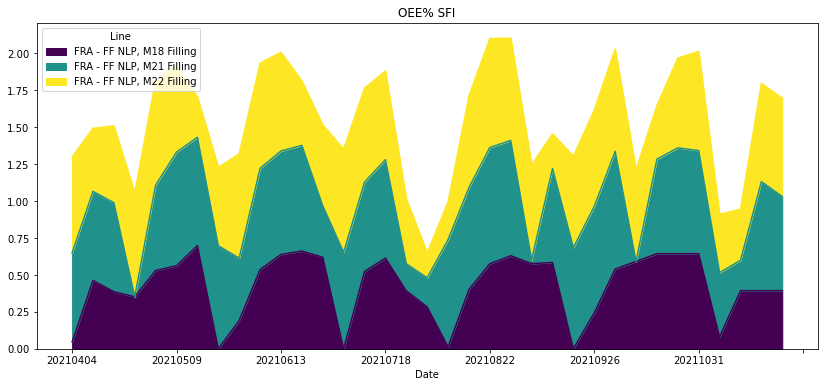

In [ ]:
df_weekly.pivot_table(index='Date', columns='Line', values='OEE %').filter(regex='M18|M21|M22').plot.area(figsize=(14,6), title='OEE% SFI', cmap='viridis')
# plt(color='')
# temp_df.pivot_table(index='Date', columns='Line', values='OEE %').plot.area(figsize=(24,10), linestyle='--') 
# plt.title('SFI OEE values%') 
# plt.xlabel('Changeover')
# plt.ylabel('OEE% % Lost')

<AxesSubplot:title={'center':'Changeover Without SFI'}, xlabel='Date'>

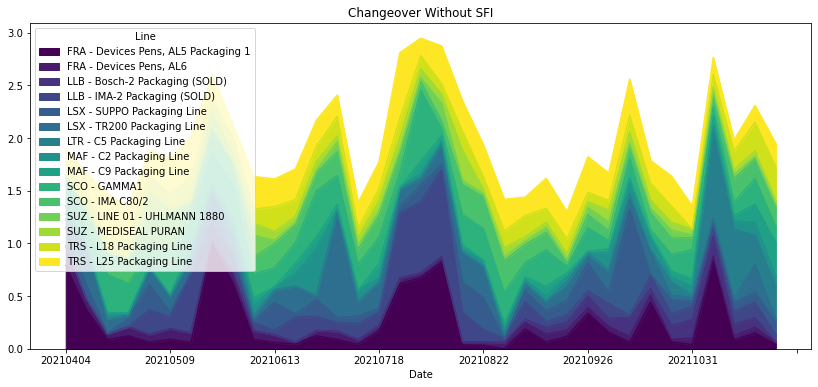

In [ ]:
df_weekly.pivot_table(index='Date', columns='Line', values='Changeover').filter(regex='Packaging|AL6|GAMMA1|IMA|LINE|MEDISEAL').plot.area(figsize=(14,6), title='Changeover Without SFI', cmap='viridis')


In [ ]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573 entries, 0 to 572
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Week                          572 non-null    object        
 1   Line                          573 non-null    object        
 2   OEE %                         572 non-null    float64       
 3   Changeover                    573 non-null    float64       
 4   Unplanned_tech_loss           573 non-null    float64       
 5   WeekOfYear                    572 non-null    float64       
 6   Year                          572 non-null    float64       
 7   Date                          573 non-null    object        
 8   Plant                         573 non-null    object        
 9   OEE  Start point              572 non-null    float64       
 10  Way to Prog Target (65%)      573 non-null    float64       
 11  McL_Start_OEE                 38

In [ ]:
pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 15
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Line                      18 non-null     object 
 1   2021-04-15 00:00:00       18 non-null     float64
 2   2021-05-13 00:00:00       18 non-null     float64
 3   2021-06-10 00:00:00       18 non-null     float64
 4   2021-07-08 00:00:00       18 non-null     float64
 5   2021-08-19 00:00:00       18 non-null     float64
 6   2021-09-16 00:00:00       18 non-null     float64
 7   2021-10-14 00:00:00       18 non-null     float64
 8   2021-11-18 00:00:00       18 non-null     float64
 9   2021-12-02 00:00:00       18 non-null     float64
 10  race_time                 18 non-null     float64
 11  prev_race_time            18 non-null     float64
 12  Plant                     18 non-null     object 
 13  position                  18 non-null     int32  
 14  gap_to_leade

In [ ]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573 entries, 0 to 572
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Week                          572 non-null    object        
 1   Line                          573 non-null    object        
 2   OEE %                         572 non-null    float64       
 3   Changeover                    573 non-null    float64       
 4   Unplanned_tech_loss           573 non-null    float64       
 5   WeekOfYear                    572 non-null    float64       
 6   Year                          572 non-null    float64       
 7   Date                          573 non-null    object        
 8   Plant                         573 non-null    object        
 9   OEE  Start point              572 non-null    float64       
 10  Way to Prog Target (65%)      573 non-null    float64       
 11  McL_Start_OEE                 38

In [ ]:
df_weekly.set_index('Date', inplace=True)

<AxesSubplot:xlabel='Date'>

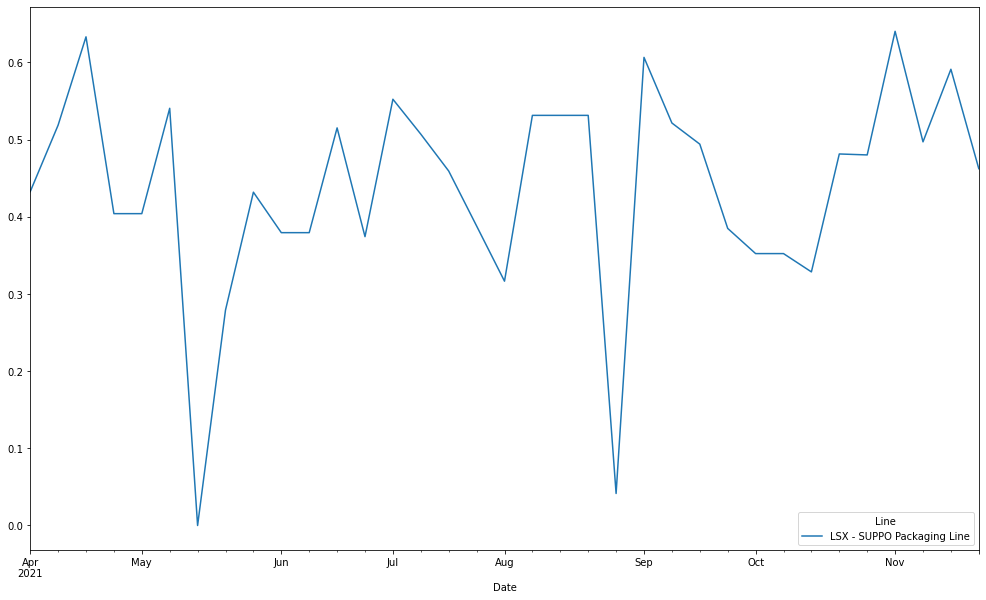

In [ ]:
df_weekly[df_weekly.Line.str.contains('SUPP')].pivot_table(index='Date', columns='Line', values='OEE %').plot(figsize=(17,10))

In [ ]:
df_weekly[df_weekly.Line.str.contains('SUPP')]

,Week,Line,OEE %,Changeover,Unplanned_tech_loss,WeekOfYear,Year,Date,Plant,OEE Start point,...,sector_8,sector_9,sector_10,sector_11,sector_12,sector_13,lap_time,Plant Line,Process,race_time
1,W13-2021,LSX - SUPPO Packaging Line,0.432432,0.178806,0.148267,13.0,2021.0,2021-04-04,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.346550,LSX - SUPPO Packaging Line,PACKAGING,88.346550
21,W14-2021,LSX - SUPPO Packaging Line,0.518594,0.132302,0.109755,14.0,2021.0,2021-04-11,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.240073,LSX - SUPPO Packaging Line,PACKAGING,88.586623
37,W15-2021,LSX - SUPPO Packaging Line,0.633037,0.009042,0.088776,15.0,2021.0,2021-04-18,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.181684,LSX - SUPPO Packaging Line,PACKAGING,88.768307
46,W16-2021,LSX - SUPPO Packaging Line,0.403974,0.073063,0.153475,16.0,2021.0,2021-04-25,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.583790,LSX - SUPPO Packaging Line,PACKAGING,89.352098
65,W17-2021,LSX - SUPPO Packaging Line,0.403974,NaN,0.514876,17.0,2021.0,2021-05-02,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.696009,LSX - SUPPO Packaging Line,PACKAGING,90.048106
83,W18-2021,LSX - SUPPO Packaging Line,0.540459,0.051256,0.123271,18.0,2021.0,2021-05-09,Lisieux,0.353021,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.143328,LSX - SUPPO Packaging Line,PACKAGING,90.191434
89,W19-2021,LSX - SUPPO Packaging Line,0.000000,0.000000,0.000000,19.0,2021.0,2021-05-16,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.815661,LSX - SUPPO Packaging Line,PACKAGING,91.007096
115,W20-2021,LSX - SUPPO Packaging Line,0.279041,0.102591,0.269244,20.0,2021.0,2021-05-23,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.271654,LSX - SUPPO Packaging Line,PACKAGING,91.278750
118,W21-2021,LSX - SUPPO Packaging Line,0.431782,0.042122,0.187659,21.0,2021.0,2021-05-30,Lisieux,0.353021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.318408,LSX - SUPPO Packaging Line,PACKAGING,91.597158
132,W22-2021,LSX - SUPPO Packaging Line,0.379348,0.007079,0.216220,22.0,2021.0,2021-06-06,Lisieux,0.353021,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.499031,LSX - SUPPO Packaging Line,PACKAGING,92.096189
